<a href="https://colab.research.google.com/github/rhirwa/predicting_housing_prices/blob/main/house_pricing_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#import the necessary libaries
from pathlib import Path 
import pandas as pd
import tarfile 
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel

In [3]:
#loads data from datasets or the url into a Pandas dataframe
def load_housing_data():
  tarball_path = Path('datasets/housing.tgz')
  if not tarball_path.is_file():
    Path('datasets').mkdir(parents = True, exist_ok = True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path = 'datasets')
  return pd.read_csv(Path("datasets/housing/housing.csv"))
housing = load_housing_data()

In [4]:
#understanding the data
housing.head()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
#categories in ocean_proximity 
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
#check the numberical attributes
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


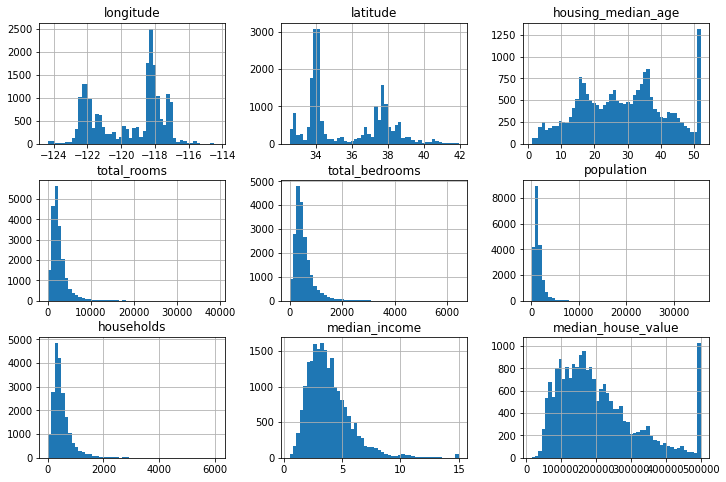

In [7]:
#investigating numerical attributes
housing.hist(bins = 50, figsize=(12, 8))
plt.show()

In [8]:
#split data into train and test sets 
def shuffle_and_split_data(data, split_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data)*split_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]
train_set, test_set = shuffle_and_split_data(housing, 0.2)

In [9]:
#check train set length
len(train_set)

16512

In [10]:
#check test set length
len(test_set)

4128

In [11]:
# consistent train, test sets generation
def is_id_in_test_set(identifier, test_ratio):
  return crc32(np.int64(identifier)) < test_ratio *2**32

def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
#establishing id for the housing data
housing_with_id = housing.reset_index() #adds index column 
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [13]:
#using most stable features as an id
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, 'id')

In [14]:
#stratified sampling of the income classes
housing['income_cat'] = pd.cut(housing['median_income'], 
                               bins = [0., 1.5, 3.0, 4.5, 6., np.inf], 
                               labels = [1, 2, 3, 4, 5])

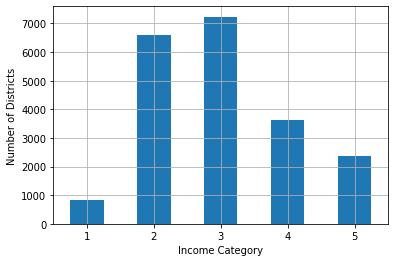

In [15]:
#visualizing our income categories
housing['income_cat'].value_counts().sort_index().plot.bar(rot = 0, grid = True)
plt.xlabel('Income Category')
plt.ylabel('Number of Districts')
plt.show()

In [16]:
#generating multiple stratified splits
splitter = StratifiedShuffleSplit(n_splits=10, test_size = 0.2, random_state= 42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing['income_cat']):
  strat_train_set_n = housing.iloc[train_index]
  strat_test_set_n = housing.iloc[test_index]
  strat_splits.append([strat_train_set_n, strat_test_set_n])

In [17]:
#just using the first split
strat_train_set, strat_test_set = strat_splits[0]

In [18]:
#a look at the income category proportions
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [19]:
#dropping the income_cat column since we don't need it anymore
for set_ in (strat_train_set, strat_test_set):
  set_.drop('income_cat', axis = 1, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [20]:
# make copy of the training set for exploration
housig = strat_train_set.copy()

<function matplotlib.pyplot.show(*args, **kw)>

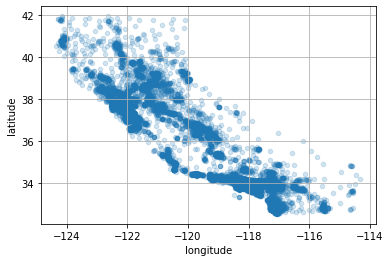

In [21]:
#visualizing the district locations on a scatterplot
housing.plot(kind='scatter', x = 'longitude', y = 'latitude', grid = True, alpha = 0.2)
plt.show

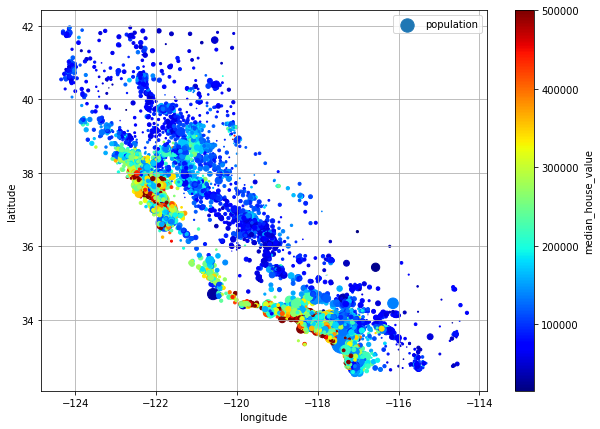

In [22]:
#looking at the housing prices
housing.plot(kind='scatter', x = 'longitude', y = 'latitude', grid = True, 
             s = housing['population']/100, label = 'population', 
             c = 'median_house_value', cmap = 'jet', colorbar = True, 
             legend = True, sharex =False, figsize = (10, 7))
plt.show()

In [23]:
#looking for correlations
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

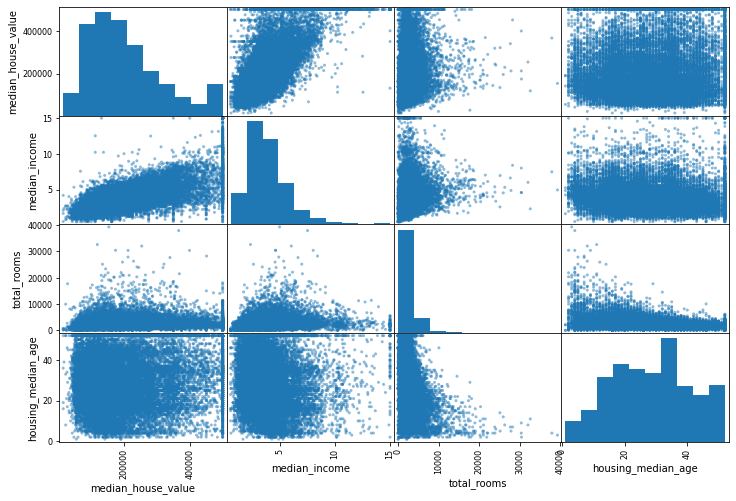

In [24]:
#check for visual correlation
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

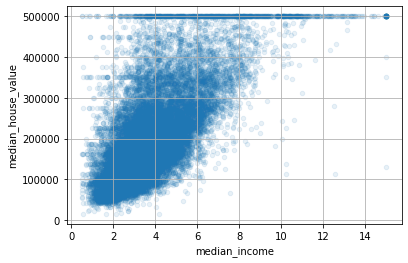

In [25]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', 
             alpha = 0.1, grid = True)
plt.show()

In [26]:
#trying to get more meaningful attributes
housing['rooms_per_house'] = housing['total_rooms'] /housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms']/ housing['total_rooms']
housing['people_per_house'] = housing['population']/ housing['households']

In [27]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688075
rooms_per_house       0.151948
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
people_per_house     -0.023737
population           -0.024650
longitude            -0.045967
latitude             -0.144160
bedrooms_ratio       -0.255880
Name: median_house_value, dtype: float64

In [28]:
#preparing for ml algorithms
housing = strat_train_set.drop('median_house_value', axis = 1)
housing_labels = strat_train_set['median_house_value'].copy()

In [29]:
#dropping n/a data methods
#housing.dropna(subset = ['total_bedrooms'], inplace = True) #drop rows
#housing.drop('total_bedrooms', axis = 1) #drop columns
#median = housing['total_bedrooms'].median() #fill with median
#housing['total_bedrooms'].fillna(median, inplace=True)

In [30]:
#better method to fill in missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

In [31]:
#leaving numerical values
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num) #fit training data
#(strategy='most_frequent'), (strategy ='constant') can support non-numberical data

SimpleImputer(strategy='median')

In [32]:
#training the imputer
imputer.statistics_
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [33]:
#fill in missing values in the training set
X = imputer.transform(housing_num)

In [34]:
#dataframa X values 
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [35]:
#encoding text attributes (categorical)
housing_cat = housing[['ocean_proximity']]
oh_encoder = OneHotEncoder()
housing_cat_encoded = oh_encoder.fit_transform(housing_cat)

In [36]:
#feature scaling
#min_max_scaler = MinMaxScaler(feature_range=(-1,1))
#housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)


In [37]:
#gaussian rbf similarity between a fixed point and some factor
age_simil_35 = rbf_kernel(housing[['housing_median_age']], [[35]], gamma = 0.1)

In [ ]:
#experimenting with inverse_transform
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [ ]:
#a simpler method
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

In [ ]:
#custom transformer (log-transformer)
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [ ]:
#hyperparameters in a customer transformation 
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

In [ ]:
#an examplary custom transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_


In [ ]:
#other estimators in custom transformers
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [ ]:
#custom transformer with kmeans clustering
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

In [ ]:
#pipeline constructor to execute series of transformations
from sklearn.pipeline import Pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('standardize', StandardScaler()),
])
#use make_pipeline when no naming needed
#use get_feature_names_out to get a nice dataframe

In [ ]:
# column transformer for both numerical and categorical values
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])
#make_column_selector() to automatically select features
#make_column_transformer() to automatically assign names

In [ ]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)

In [ ]:
#pipeline to transform the training set altogether
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)

In [ ]:
#trying linear regression model
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

In [ ]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)
housing_labels.iloc[:5].values

In [ ]:
#rmse measure for performance 
from sklearn.metrics import mean_squared_error
lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared = False)

In [ ]:
#trying decision trees
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

In [ ]:
#evaluate
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared = False)
tree_rmse

In [ ]:
#using k-fold cross-validation 
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
#look at teh results 
pd.Series(tree_rmses).describe()

In [ ]:
#trying random forest regressor
from sklearn.ensemble import RandomForestRegressor
forest_reg = make_pipeline(preprocessing, 
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring='neg_root_mean_squared_error', cv=10)

In [ ]:
#look at the scores 
pd.Series(forest_rmses).desribe()

In [ ]:
#using grid search cv for best hyperparameters
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

In [ ]:
#best combination of parameters
grid_search.best_params_
#best estimator 
grid_search.best_estimator_
#evaluation scores
grid_search.cv_results_

In [ ]:
#randomized search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)
# other search methods HalvingRandomSearchCV and HalvingGridSearchCV

In [ ]:
#best models 
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

In [ ]:
#sorting feature importances 
sorted(zip(feature_importances,
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)
#automatic feature importance search 
#sklearn.feature_selection.SelectFromModel

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)  # prints 41424.40026462184

In [ ]:
#precise estimate
from scipy import stats
>>> confidence = 0.95
>>> squared_errors = (final_predictions - y_test) ** 2
>>> np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
...                          loc=squared_errors.mean(),
...                          scale=stats.sem(squared_errors)))

In [ ]:
#saving a model 
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

In [ ]:
#load model 
import joblib
[...]  # import KMeans, BaseEstimator, TransformerMixin, rbf_kernel, etc.

def column_ratio(X): [...]
def ratio_name(function_transformer, feature_names_in): [...]
class ClusterSimilarity(BaseEstimator, TransformerMixin): [...]

final_model_reloaded = joblib.load("my_california_housing_model.pkl")

new_data = [...]  # some new districts to make predictions for
predictions = final_model_reloaded.predict(new_data)